In [1]:
from pathlib import Path
if Path.cwd().parent.stem == 't1':
    %cd ..

/home/step/Personal/UCH/2021-sem1/VisionComp/t1


In [2]:
import train
from train import *
from dataset import ClothingSmall, parse_function, train_preprocess
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
print(train.__doc__)


jsaavedr, 2020
This allows you to train and test your model

Before using this program, set the path where the folder "covnet2"  is stored.
To use train.py, you will require to send the following parameters :
 * -config : A configuration file where a set of parameters for data construction and trainig is set.
 * -name: A section name in the configuration file.
 * -mode: [train, test] for training, testing, or showing  variables of the current model. By default this is set to 'train'
 * -save: Set true for saving the model


 Extension made by Victor Faraggi, 2021

 Added modularity. Now you can import the following functions:
    - create_config(name, config_file=None, config_str=None)
        -> return a ConfigurationFile from config_file path or config_str
    - parse_config(config)
        -> returns dict w/ tfr_files
    - load_dataset(config, tfr_train_file, tfr_test_file)
        -> returns a dict w/ train/test datasets, mean_image, input_shape and number_of_classes
    - create

# ResNext-50


In [4]:
resnext50_config = \
"""[FASHION-RESNEXT50]
# Training Related
NUM_EPOCHS = 20
NUM_CLASSES = 19
BATCH_SIZE = 64
SNAPSHOT_STEPS = 500
VALIDATION_STEPS = 100
LEARNING_RATE = 0.003
DECAY_STEPS = 40000
USE_L2 = True
WEIGHT_DECAY = 1e-2

SNAPSHOT_DIR = snapshots/snapshots-resnext/

# Dataset Related
DATA_DIR = data/clothing-small/
SHUFFLE_SIZE = 10000
CHANNELS = 3
IMAGE_TYPE = IMAGE
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#for tf_records to use multithreads
USE_MULTITHREADS = True
NUM_THREADS = 10

#CKPFILE is used for fine tunning
#CKPFILE =/home/step/Personal/UCH/2021-sem1/VisionComp/t1/chks
"""

with open("configs/t1_resnext50.config", 'w') as conf:
    conf.write(resnext50_config)

## Configuration and Dataset

In [5]:
config = create_config("FASHION-RESNEXT50", "configs/t1_resnext50.config")
tfr_files = parse_config(config, mode='train')
datasets = load_dataset(config, tfr_files['train'], tfr_files['test'], 'train')

In [6]:
from dataset import ClothingSmall

process_func = lambda img, label : train_preprocess(img, label, seed=[8, 8])

csDataset = ClothingSmall(data_dir = config.get_data_dir())

csDataset.prepare()

csDataset.make_ds(parse_function, process_func)


# datasets = {
#     'train' : csDataset.train_ds,
#     'test' : csDataset.test_ds
# }


## Create Callbacks

In [8]:
tb_cb, chk_cb = create_cbs(config)

#### LRFinder

In [10]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, dataset, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * 31977 / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(dataset, batch_size=batch_size, epochs=epochs, callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [11]:
def determineLearningRate(model, dataset, opt):    
    batch_size = 128
    epochs = 5
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    lr_finder = LRFinder(model)
    lr_finder.find(dataset, start_lr=1e-5, end_lr=1, batch_size=batch_size, epochs=epochs)
    lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
    plt.show()
    return model

Model is Resnext-50
(224, 224, 3)
Model: "res_next_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/5
500/500 [==============================] - 112s 202ms/step - loss: 5.3761 - accuracy: 0.0509
Epoch 2/5
500/500 [==============================] - 103s 195ms/step - loss: 7.0277 - accuracy: 0.0620
Epoch 3/5
500/500 [==============================] - 61s 112ms/step - loss: nan - accuracy: 0.0635


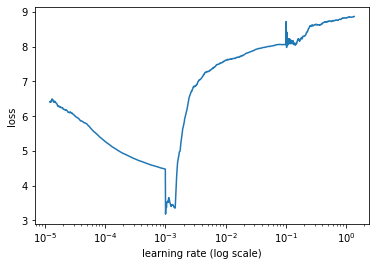

In [12]:
model = create_model(config, 'resnext', csDataset.input_shape, use_mixed=True)
determineLearningRate(model, datasets['train'], tf.keras.optimizers.SGD())

In [13]:
model = create_model(config, 'resnext', csDataset.input_shape, use_mixed=True)
determineLearningRate(model, datasets['train'], tf.keras.optimizers.Adam())

Model is Resnext-50
(224, 224, 3)
Model: "res_next_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________
Epoch 1/5
500/500 [==============================] - 104s 189ms/step - loss: 8.0839 - accuracy: 0.0535
Epoch 2/5
500/500 [==============================] - 101s 190ms/step - loss: 8.2275 - accuracy: 0.0621
Epoch 3/5
500/500 [==============================] - 97s 185ms/step - loss: 8.1609 - accuracy: 0.0393
Epoch 4/5
160/500 [========

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/step/miniconda3/envs/vision-tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-e3b01b74cd9d>", line 2, in <module>
    determineLearningRate(model, datasets['train'], tf.keras.optimizers.Adam())
  File "<ipython-input-11-fdfd278c5e3a>", line 9, in determineLearningRate
    lr_finder.find(dataset, start_lr=1e-5, end_lr=1, batch_size=batch_size, epochs=epochs)
  File "<ipython-input-10-ed1c17934bfc>", line 55, in find
    self.model.fit(dataset, batch_size=batch_size, epochs=epochs, callbacks=[callback])
  File "/home/step/miniconda3/envs/vision-tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1183, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/step/miniconda3/envs/vision-tf/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 872, in __call__
    res

TypeError: object of type 'NoneType' has no len()

In [ ]:
model = create_model(config, 'resnext', csDataset.input_shape, use_mixed=True)
determineLearningRate(model, datasets['train'], tf.keras.optimizers.Nadam())

## Optimizer

In [7]:
cosine_sched = create_scheduler(config)
opt = create_opt('nadam', config)

## Model

In [9]:
model = create_model(config, 'resnext', csDataset.input_shape, use_mixed=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnext-50
(224, 224, 3)
Model: "res_next"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23033024  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,071,955
Trainable params: 23,011,283
Non-trainable params: 60,672
_________________________________________________________________


## Run

In [ ]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)

In [ ]:
history = run_model('train', model, opt, datasets, config, [chk_cb], [tb_cb])

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()